# Notebook Implementation

DATASET BIG VERSION: https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-dataset?resource=download


MILESTONE2 DOC: https://docs.google.com/document/d/1YPiOkxVM2ewKy4txhegV_R2H0X3uYl_r403WvEyVg7Y/edit?tab=t.0


DATASET: https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-small

IMGBB: https://owen-zhang.imgbb.com/

SERPAPI: https://serpapi.com/dashboard

GEMINI: https://aistudio.google.com/app/api-keys


In [ ]:
pip install google-search-results

  Preparing metadata (setup.py) ... done
  Created wheel for google-search-results: filename=google_search_results-2.4.2-py3-none-any.whl size=32010 sha256=d11f3366cf5371f7114affb98548e7aef72f8de3fdf8a262fca20341406308ee
  Stored in directory: /root/.cache/pip/wheels/0c/47/f5/89b7e770ab2996baf8c910e7353d6391e373075a0ac213519e
Successfully built google-search-results


In [ ]:
!pip install flask flask-cors pyngrok Pillow

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import drive, files
import os
from serpapi import GoogleSearch
from google.colab import userdata
from IPython.display import display, Image
import requests
from PIL import Image
import PIL
import glob
import pandas as pd
import torch
from sentence_transformers import SentenceTransformer, util
import matplotlib.pyplot as plt
import base64
import json
from google import genai
from IPython.display import HTML, display
import shutil

In [ ]:
drive.mount('/content/drive')
uploaded = files.upload()  # choose your kaggle.json

Mounted at /content/drive


Saving kaggle.json to kaggle.json


In [ ]:
shutil
drive_dir = '/content/drive/MyDrive/secrets/kaggle'
os.makedirs(drive_dir, exist_ok=True)
shutil.move('kaggle.json', f'{drive_dir}/kaggle.json')

'/content/drive/MyDrive/secrets/kaggle/kaggle.json'

In [ ]:
local_dir = "/root/.kaggle"
os.makedirs(local_dir, exist_ok=True)
shutil.copy(f'{drive_dir}/kaggle.json', f'{local_dir}/kaggle.json')
os.chmod(f'{local_dir}/kaggle.json', 600)

In [ ]:
!kaggle datasets download -d paramaggarwal/fashion-product-images-small -p /content/data

Dataset URL: https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-small
License(s): MIT
 92% 518M/565M [00:10<00:01, 36.0MB/s]
100% 565M/565M [00:10<00:00, 54.0MB/s]


In [ ]:
!unzip -q /content/data/fashion-product-images-small.zip -d /content/data/fashion_small

In [ ]:
image_paths = glob.glob('/content/data/fashion_small/images/*.jpg')
print('Images:', len(image_paths))
df = pd.read_csv(
    '/content/data/fashion_small/styles.csv',
    engine='python',
    on_bad_lines='skip'   # or 'warn' if you want to see them
)

Images: 44441


In [ ]:
image_root = "/content/data/fashion_small/images"   # adjust if needed
all_img_paths = sorted(glob.glob(f"{image_root}/*.jpg"))

In [ ]:
torch.cuda.is_available()

True

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:", device)
clip = SentenceTransformer('clip-ViT-B-32', device=device)

Device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/604 [00:00<?, ?B/s]

0_CLIPModel/pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

0_CLIPModel/model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [ ]:
clip.to('cuda')

SentenceTransformer(
  (0): CLIPModel()
)

In [ ]:
def load_image(path):
    try:
        return Image.open(path).convert("RGB")
    except:
        return None

all_imgs = [load_image(p) for p in all_img_paths]
valid = [i for i, img in enumerate(all_imgs) if img is not None]
all_img_paths = [all_img_paths[i] for i in valid]
all_imgs = [all_imgs[i] for i in valid]

all_img_embs = clip.encode(all_imgs, convert_to_tensor=True, show_progress_bar=True)
print("Embeddings:", all_img_embs.shape)

Batches:   0%|          | 0/1389 [00:00<?, ?it/s]

Embeddings: torch.Size([44441, 512])


In [ ]:
def search_by_text(query, img_paths, img_embs, top_k=5):
    """
    query: text string, like "white tennis skirt"
    img_paths: list of .jpg paths
    img_embs: tensor of shape (N, dim)
    """
    # Encode text
    q_emb = clip.encode([query], convert_to_tensor=True)

    # Cosine similarity between text and each image
    scores = util.cos_sim(q_emb, img_embs)[0]

    # Best matches
    topk_idx = torch.topk(scores, k=top_k).indices.tolist()

    # Return both path & similarity score
    return [(img_paths[i], float(scores[i])) for i in topk_idx]

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# RETURNS PATH AND SCORE
def show_outfits_from_text(query, img_paths, img_embs, top_k=1):
    # Get best matches (paths + scores)
    results = search_by_text(query, img_paths, img_embs, top_k=top_k)

    print(f"Query: {query}")
    for rank, (path, score) in enumerate(results, start=1):
        print(f"{rank}. {path}  (score: {score:.3f})")

    # Plot images in a row
    plt.figure(figsize=(4 * top_k, 4))
    for i, (path, score) in enumerate(results):
        img = Image.open(path).convert("RGB")
        ax = plt.subplot(1, top_k, i + 1)
        ax.imshow(img)
        ax.set_title(f"{i+1}: {score:.2f}")
        ax.axis("off")
    plt.show()

    return path, score

In [ ]:
# 250 SEARCHES MAX for SERPAPI
SERPAPI_API_KEY = userdata.get("SERPAPI_API_KEY")

IMGBB_API_KEY = userdata.get("IMGBB_API_KEY")

In [ ]:
import base64

def upload_to_imgbb(local_path: str) -> str:
    """
    Uploads an image file to ImgBB and returns a public URL.
    """
    with open(local_path, "rb") as f:
        img_b64 = base64.b64encode(f.read())

    url = "https://api.imgbb.com/1/upload"
    payload = {
        "key": IMGBB_API_KEY,
        "image": img_b64,  # base64-encoded image data
    }
    res = requests.post(url, data=payload)
    res.raise_for_status()
    data = res.json()["data"]
    return data["url"]  # or data["display_url"]

In [ ]:
def extract_price(product) -> str | None:
    """Try to extract a human-readable price string from a Lens result."""
    price = product.get("price")

    # Case 1: dict with structured fields
    if isinstance(price, dict):
        # common patterns
        raw = price.get("raw")          # e.g. "$49.99"
        value = price.get("value")      # e.g. 49.99
        currency = price.get("currency")  # e.g. "USD"

        if raw:
            return str(raw)
        if value is not None and currency:
            return f"{currency} {value}"
        if value is not None:
            return str(value)

    # Case 2: already a string
    if isinstance(price, str):
        return price

    # Case 3: sometimes price-ish text is stored in extensions
    exts = product.get("extensions")
    if isinstance(exts, list):
        for ext in exts:
            if isinstance(ext, str) and any(sym in ext for sym in ["$", "£", "€", "¥"]):
                return ext

    # Nothing found
    return None

In [ ]:
def find_similar_clothing_on_web(image_url, max_results: int = 5) -> list[dict]:
    if not SERPAPI_API_KEY or SERPAPI_API_KEY == "YOUR_SERPAPI_API_KEY":
        raise RuntimeError("Set SERPAPI_API_KEY env var or hard-code your API key.")

    params = {
        "api_key": SERPAPI_API_KEY,
        "engine": "google_lens",
        "url": image_url,
        "hl": "en",
        "country": "us",
        "type": "products",
    }

    search = GoogleSearch(params)
    response = search.get_dict()
    visual_matches = response.get("visual_matches", []) or []

    results = []
    for product in visual_matches[:max_results]:
        price_value = extract_price(product)

        results.append(
            {
                "title": product.get("title"),
                "product_url": product.get("link"),
                "source": product.get("source"),
                "price": price_value,  # now uses generalized extraction
                "thumbnail": product.get("thumbnail") or product.get("image"),
            }
        )

    return results

In [ ]:
pip install google-genai

In [ ]:
user_wardrobe_text = "cozy winter streetwear fit for NYC"

contents = f"""
You are a fashion styling assistant.

Given a free-form wardrobe or outfit idea, your task is to break it down into
a list of specific clothing item descriptions that could be used as prompts
for another model.

INPUT:
- A user wardrobe idea, which can be anything from a single item
  ("black turtleneck") to a whole look ("cozy winter streetwear fit for NYC").

OUTPUT:
- Return ONLY a valid JSON array of strings.
- Each string describes ONE clothing item in detail.
- Do not wrap the JSON in backticks or add any explanation.

REQUIREMENTS FOR EACH STRING:
- Start with the garment category (e.g. "oversized puffer jacket", "slim-fit chinos").
- Add key attributes: fit, style, color, material, and notable design details.
- Aim for ~8–20 words per item.
- No mention of models, bodies, genders, faces, poses, or backgrounds.
- No numbering, no bullet points, no extra keys — just plain strings.

HOW MANY ITEMS TO RETURN:
- Dynamically decide based on the input:
  - If the idea sounds like a full outfit, include top layer(s), inner layer(s),
    bottoms, footwear, and key accessories (e.g. hat, scarf, bag, gloves).
  - If the idea is minimal or focused on one item, return just the relevant
    number of detailed item descriptions.
- Typically 3–10 items, but can be fewer or more if naturally implied.

EXAMPLES OF DESIRED OUTPUT STYLE (FORMAT ONLY, NOT CONTENT):
[
  "oversized wool-blend camel overcoat with notch lapel and hidden button closure",
  "chunky ribbed charcoal turtleneck sweater, relaxed fit, thick knit texture",
  "tapered dark indigo denim jeans with clean wash and minimal distressing",
  "black leather Chelsea boots with low heel and matte finish",
  "soft cashmere grey beanie with folded cuff and subtle knit pattern",
  "long woven plaid scarf in muted navy and forest green"
]

Now process this wardrobe idea and produce the JSON array of strings:

\"\"\"{user_wardrobe_text}\"\"\"
"""

In [ ]:
import json
def parse_clothing_output(response_text: str):
    """
    Takes Gemini response.text (which should be a JSON array of strings)
    and returns a Python list of strings.
    """
    # Strip whitespace just in case
    cleaned = response_text.strip()

    # Some models escape newlines like "\\n" — json.loads handles this fine
    try:
        return json.loads(cleaned)
    except json.JSONDecodeError:
        # If for some reason Gemini returns extra text, try to isolate JSON
        start = cleaned.find("[")
        end = cleaned.rfind("]") + 1
        if start == -1 or end == -1:
            raise ValueError("No JSON array found in response_text.")
        return json.loads(cleaned[start:end])

In [ ]:
# LLM wrapper
from google import genai

FASHIONGENAI_KEY = userdata.get('FASHIONGENAI_KEY')

client = genai.Client(api_key=FASHIONGENAI_KEY)

response = client.models.generate_content(
    model="gemini-2.5-flash",
    contents=contents
)

print(response.text)

[
  "oversized black matte puffer jacket with a large hood and warm synthetic insulation",
  "oversized cream heavyweight fleece hoodie with a dropped shoulder and ribbed cuffs",
  "relaxed fit charcoal grey ripstop cargo pants with multiple utility pockets and elasticized cuffs",
  "chunky black waterproof utility boots with thick lug soles and a padded collar",
  "soft knit black wool blend beanie with a wide folded cuff",
  "thick chunky ribbed knit grey marl scarf, long and extra wide",
  "insulated black touchscreen compatible gloves with a subtle streetwear brand logo"
]


In [ ]:
from IPython.display import HTML, display

def display_table(similar_items):
  rows_html = []

  # header row
  rows_html.append("""
  <tr>
    <th>Image</th>
    <th>Title</th>
    <th>Source</th>
    <th>Price</th>
    <th>Link</th>
  </tr>
  """)

  for p in similar_items:
      img_html = (
          f'<img src="{p["thumbnail"]}" style="max-width:120px; height:auto;">'
          if p["thumbnail"] else "(no image)"
      )
      link_html = (
          f'<a href="{p["product_url"]}" target="_blank">View Product</a>'
          if p["product_url"] else "(no link)"
      )
      rows_html.append(f"""
      <tr>
        <td>{img_html}</td>
        <td>{p["title"]}</td>
        <td>{p["source"]}</td>
        <td>{p["price"]}</td>
        <td>{link_html}</td>
      </tr>
      """)

  table_html = f"""
  <h3>Original item</h3>
  <p><img src="{public_url}" style="max-width:150px; height:auto;"></p>

  <h3>Similar items (web)</h3>
  <table border="1" cellpadding="6" cellspacing="0" style="border-collapse:collapse;">
    {''.join(rows_html)}
  </table>
  """
  display(HTML(table_html))

In [ ]:
def text_to_links(text_input, all_img_paths, all_img_embs, top_k=1, max_results=2):
  path, score = show_outfits_from_text(text_input, all_img_paths, all_img_embs, top_k=1)
  public_url = upload_to_imgbb(path)
  print("Public image URL:", public_url)
  similar_items = find_similar_clothing_on_web(public_url, max_results)
  return similar_items, path, public_url, score

In [ ]:
clothing_arr = parse_clothing_output(response.text)
clothing_arr

['oversized black matte puffer jacket with a large hood and warm synthetic insulation',
 'oversized cream heavyweight fleece hoodie with a dropped shoulder and ribbed cuffs',
 'relaxed fit charcoal grey ripstop cargo pants with multiple utility pockets and elasticized cuffs',
 'chunky black waterproof utility boots with thick lug soles and a padded collar',
 'soft knit black wool blend beanie with a wide folded cuff',
 'thick chunky ribbed knit grey marl scarf, long and extra wide',
 'insulated black touchscreen compatible gloves with a subtle streetwear brand logo']

Query: oversized black puffer jacket with a matte finish, hooded design, and warm down insulation
1. /content/data/fashion_small/images/17897.jpg  (score: 0.333)


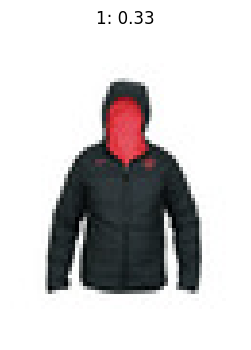

Public image URL: https://i.ibb.co/XkZMPbsN/bc7f0ca9414d.jpg


Image,Title,Source,Price,Link
,THE NORTH FACE MENS RESOLVE HOODED JACKET -AR9T- ASPHALT GREY / RED- M- NEW | eBay,eBay,None,View Product
,The North Face | Jackets & Coats | North Face Jacket | Poshmark,Poshmark,None,View Product


In [ ]:
similar_items, path, public_url, score = text_to_links("oversized black puffer jacket with a matte finish, hooded design, and warm down insulation", all_img_paths, all_img_embs, top_k=1, max_results=2)
display_table(similar_items)

# GRADIO APP FOR DEMO

In [ ]:
%%writefile services.py
"""
services.py – glue between  model code and the Flask/Gradio frontends.
  1. Implement clothing_pipeline(user_text) to produce clothing_arr.
  2. Implement text_to_links_with_steps(...) that uses embeddings, ImgBB,
     SerpAPI, etc., and returns per-step details.
"""

import os
import json
import base64
import requests
import matplotlib.pyplot as plt

from google.colab import drive, files, userdata  # type: ignore
from IPython.display import HTML, display  # type: ignore

from PIL import Image
import torch
from sentence_transformers import SentenceTransformer, util
from serpapi import GoogleSearch
from google import genai

# -------------------------------------------------------------------
# 1. GLOBALS – load your embeddings and paths here
# -------------------------------------------------------------------

# TODO: Set these after computing embeddings.
all_img_paths: list[str] = []               # e.g. list of image file paths
all_img_embs: torch.Tensor | None = None    # shape (N, D) tensor of embeddings

_text_model: SentenceTransformer | None = None


def get_text_model():
    global _text_model
    if _text_model is None:
        # Use the SAME model family you used when creating the image embeddings
        _text_model = SentenceTransformer("clip-ViT-B-32")
    return _text_model


# -------------------------------------------------------------------
# 2. Clothing pipeline – from user text to clothing_arr
# -------------------------------------------------------------------
def clothing_pipeline(user_text: str) -> list[str]:
    """
    Turn the original text input into an array of clothing strings.
    E.g. "I want a comfy fall outfit..." -> ["brown knit sweater", "black jeans", ...]
    Uses Gemini to turn the free-form outfit text into a JSON array of strings.
    """

    contents = f"""
    You are a fashion styling assistant.

    Given a free-form wardrobe or outfit idea, your task is to break it down into
    a list of specific clothing item descriptions that could be used as prompts
    for another model.

    INPUT:
    - A user wardrobe idea, which can be anything from a single item
      ("black turtleneck") to a whole look ("cozy winter streetwear fit for NYC").

    OUTPUT:
    - Return ONLY a valid JSON array of strings.
    - Each string describes ONE clothing item in detail.
    - Do not wrap the JSON in backticks or add any explanation.

    REQUIREMENTS FOR EACH STRING:
    - Start with the garment category (e.g. "oversized puffer jacket", "slim-fit chinos").
    - Add key attributes: fit, style, color, material, and notable design details.
    - Aim for ~8–20 words per item.
    - No mention of models, bodies, genders, faces, poses, or backgrounds.
    - No numbering, no bullet points, no extra keys — just plain strings.

    HOW MANY ITEMS TO RETURN:
    - Dynamically decide based on the input:
      - If the idea sounds like a full outfit, include top layer(s), inner layer(s),
        bottoms, footwear, and key accessories (e.g. hat, scarf, bag, gloves).
      - If the idea is minimal or focused on one item, return just the relevant
        number of detailed item descriptions.
    - Typically 3–10 items, but can be fewer or more if naturally implied.

    EXAMPLES OF DESIRED OUTPUT STYLE (FORMAT ONLY, NOT CONTENT):
    [
      "oversized wool-blend camel overcoat with notch lapel and hidden button closure",
      "chunky ribbed charcoal turtleneck sweater, relaxed fit, thick knit texture",
      "tapered dark indigo denim jeans with clean wash and minimal distressing",
      "black leather Chelsea boots with low heel and matte finish",
      "soft cashmere grey beanie with folded cuff and subtle knit pattern",
      "long woven plaid scarf in muted navy and forest green"
    ]

    Now process this wardrobe idea and produce the JSON array of strings:

    \"\"\"{user_text}\"\"\"
    """

    def parse_clothing_output(response_text: str) -> list[str]:
        cleaned = response_text.strip()
        try:
            return json.loads(cleaned)
        except json.JSONDecodeError:
            start = cleaned.find("[")
            end = cleaned.rfind("]") + 1
            if start == -1 or end == 0:
                raise ValueError("No JSON array found in LLM response.")
            return json.loads(cleaned[start:end])

    # LLM wrapper
    FASHIONGENAI_KEY = userdata.get("FASHIONGENAI_KEY") # TODO: replace with your key
    client = genai.Client(api_key=FASHIONGENAI_KEY)

    response = client.models.generate_content(
        model="gemini-2.5-flash",
        contents=contents,
    )

    clothing_arr = parse_clothing_output(response.text)
    if not isinstance(clothing_arr, list):
        raise ValueError("Gemini did not return a JSON array of strings.")
    return clothing_arr


# -------------------------------------------------------------------
# 3. Embedding search + web search helpers
# -------------------------------------------------------------------
def search_by_text(
    query: str,
    img_paths: list[str],
    img_embs: torch.Tensor,
    top_k: int = 1,
) -> list[tuple[str, float]]:
    """
    Given a text query and pre-computed image embeddings, return the top_k
    (image_path, similarity_score) matches.
    """
    if img_embs is None or len(img_paths) == 0:
        raise ValueError("all_img_paths/all_img_embs are not initialized.")

    model = get_text_model()
    query_emb = model.encode(query, convert_to_tensor=True)

    # DEBUG PRINTS
    print(">>> DEBUG in search_by_text")
    print("query_emb.shape:", query_emb.shape)
    print("img_embs.shape:", img_embs.shape)

    sims = util.cos_sim(query_emb, img_embs)[0]  # (N,)

    k = min(top_k, sims.shape[0])
    scores, indices = torch.topk(sims, k=k)

    results: list[tuple[str, float]] = []
    for score, idx in zip(scores, indices):
        results.append((img_paths[int(idx)], float(score)))
    return results

SERPAPI_API_KEY = userdata.get('SERPAPI_API_KEY') # TODO: replace
IMGBB_API_KEY = userdata.get('IMGBB_API_KEY') # TODO: replace

def upload_to_imgbb(local_path: str) -> str:
    """
    Upload an image file to ImgBB and return a public URL.
    """
    with open(local_path, "rb") as f:
        img_b64 = base64.b64encode(f.read())

    url = "https://api.imgbb.com/1/upload"
    payload = {
        "key": IMGBB_API_KEY,
        "image": img_b64,
    }
    res = requests.post(url, data=payload)
    res.raise_for_status()
    data = res.json()["data"]
    return data["url"]  # or data["display_url"]


def extract_price(product) -> str | None:
    """
    Try to extract a human-readable price string from a SerpAPI Lens result.
    """
    price = product.get("price")

    if isinstance(price, dict):
        raw = price.get("raw")
        value = price.get("value")
        currency = price.get("currency")

        if raw:
            return str(raw)
        if value is not None and currency:
            return f"{currency} {value}"
        if value is not None:
            return str(value)

    if isinstance(price, str):
        return price

    exts = product.get("extensions")
    if isinstance(exts, list):
        for ext in exts:
            if isinstance(ext, str) and any(sym in ext for sym in ["$", "£", "€", "¥"]):
                return ext

    return None


def find_similar_clothing_on_web(image_url: str, max_results: int = 5) -> list[dict]:
    """
    Use SerpAPI + Google Lens to find visually similar clothing products.
    """
    if not SERPAPI_API_KEY or SERPAPI_API_KEY == "YOUR_SERPAPI_API_KEY":
        raise RuntimeError("Set SERPAPI_API_KEY before calling find_similar_clothing_on_web.")

    params = {
        "api_key": SERPAPI_API_KEY,
        "engine": "google_lens",
        "url": image_url,
        "hl": "en",
        "country": "us",
        "type": "products",
    }
    search = GoogleSearch(params)
    response = search.get_dict()
    visual_matches = response.get("visual_matches", []) or []

    results: list[dict] = []
    for product in visual_matches[:max_results]:
        price_value = extract_price(product)
        results.append(
            {
                "title": product.get("title"),
                "product_url": product.get("link"),
                "source": product.get("source"),
                "price": price_value,
                "thumbnail": product.get("thumbnail") or product.get("image"),
            }
        )
    return results


# -------------------------------------------------------------------
# 4. Wrapper that returns exactly what frontend needs
# -------------------------------------------------------------------
def text_to_links_with_steps(
    clothing_text: str,
    top_k: int = 2,
    max_results: int = 3,
) -> dict:
    """
    For a single clothing_text (e.g. "oversized black puffer jacket..."),
    1) find best local image match via embeddings,
    2) upload that image to ImgBB,
    3) query SerpAPI/Google Lens for visually similar products.

    Returns:
    {
      "clothing_text": str,
      "local_matches": [
        {
          "path": str,
          "score": float,
          "public_url": str
        }
      ],
      "web_items": [
        {
          "title": str,
          "product_url": str,
          "source": str,
          "price": str | None,
          "thumbnail": str | None
        },
        ...
      ]
    }
    """
    if all_img_embs is None or len(all_img_paths) == 0:
        raise ValueError(
            "all_img_paths/all_img_embs are not set. "
            "Load your dataset image paths and embeddings before calling this."
        )

    # 1. Find best local image(s)
    matches = search_by_text(clothing_text, all_img_paths, all_img_embs, top_k=top_k)
    if not matches:
        raise ValueError(f"No embedding matches found for clothing_text: {clothing_text}")

    # Take the best match
    best_path, best_score = matches[0]

    # 2. Upload that image to ImgBB
    public_url = upload_to_imgbb(best_path)

    # 3. Search web for visually similar clothing items
    similar_items = find_similar_clothing_on_web(public_url, max_results=max_results)

    local_matches = [
        {
            "path": best_path,
            "score": float(best_score),
            "public_url": public_url,
        }
    ]

    return {
        "clothing_text": clothing_text,
        "local_matches": local_matches,
        "web_items": similar_items,
    }


# -------------------------------------------------------------------
# 5. Full pipeline – from user_text to EVERYTHING needed by frontend
# -------------------------------------------------------------------
def run_full_pipeline(user_text: str, top_k: int = 2, max_results: int = 3) -> dict:
    """
    High-level function called by Flask/Gradio:
      1. Build clothing_arr from user_text
      2. For each string in clothing_arr, run text_to_links_with_steps
    """
    clothing_arr = clothing_pipeline(user_text)

    per_item_results = []
    for clothing_text in clothing_arr:
        step_result = text_to_links_with_steps(
            clothing_text,
            top_k=top_k,
            max_results=max_results,
        )
        per_item_results.append(step_result)

    return {
        "user_text": user_text,
        "clothing_arr": clothing_arr,
        "results": per_item_results,
    }


Writing services.py


In [ ]:
import importlib, services
importlib.reload(services)

image_root = "/content/data/fashion_small/images"   # adjust if needed
all_img_paths = sorted(glob.glob(f"{image_root}/*.jpg"))

def load_image(path):
    try:
        return Image.open(path).convert("RGB")
    except:
        return None

all_imgs = [load_image(p) for p in all_img_paths]
valid = [i for i, img in enumerate(all_imgs) if img is not None]
all_img_paths = [all_img_paths[i] for i in valid]
all_imgs = [all_imgs[i] for i in valid]

all_img_embs = clip.encode(all_imgs, convert_to_tensor=True, show_progress_bar=True)
print("Embeddings:", all_img_embs.shape)

services.all_img_paths = all_img_paths          # list of image paths
services.all_img_embs = all_img_embs    # torch.Tensor of shape (N, D)

Batches:   0%|          | 0/1389 [00:00<?, ?it/s]

Embeddings: torch.Size([44441, 512])


In [ ]:
import services
from sentence_transformers import util

m = services.get_text_model()
q_emb = m.encode("oversized black puffer jacket", convert_to_tensor=True)
print("q_emb:", q_emb.shape)  # should be [512]

img_embs = services.all_img_embs
print("img_embs:", img_embs.shape)  # should be [44441, 512]

sims = util.cos_sim(q_emb, img_embs)
print("sims:", sims.shape)  # should be [1, 44441]

q_emb: torch.Size([512])
img_embs: torch.Size([44441, 512])
sims: torch.Size([1, 44441])


In [ ]:
%%writefile app.py
# from flask import Flask, render_template_string, request
from services import run_full_pipeline

# app = Flask(__name__)

TEMPLATE = """
<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <title>AI Outfit Finder</title>
  <meta name="viewport" content="width=device-width, initial-scale=1">

  <!-- Bootstrap for quick decent styling -->
  <link
    href="https://cdn.jsdelivr.net/npm/bootstrap@5.3.2/dist/css/bootstrap.min.css"
    rel="stylesheet"
  >

  <style>
    body {
      background-color: #f5f5f7;
    }
    .page-wrapper {
      max-width: 960px;
      margin: 40px auto;
      padding: 24px;
      background: white;
      border-radius: 16px;
      box-shadow: 0 12px 30px rgba(0,0,0,0.08);
    }
    .item-card {
      border-radius: 14px;
      border: 1px solid #eee;
      padding: 16px;
      margin-bottom: 20px;
      background-color: #fafafa;
    }
    .item-image {
      max-width: 220px;
      border-radius: 12px;
      box-shadow: 0 8px 18px rgba(0,0,0,0.1);
    }
    .badge-label {
      font-size: 0.75rem;
    }
    table {
      font-size: 0.9rem;
    }
    .outfit-pill {
      display: inline-block;
      padding: 4px 10px;
      border-radius: 999px;
      background: #eef2ff;
      color: #312e81;
      margin: 2px 6px 2px 0;
      font-size: 0.85rem;
    }
  </style>
</head>

<body>
  <div class="page-wrapper">
    <h1 class="mb-3">AI Outfit Finder</h1>
    <p class="text-muted mb-4">
      Type any outfit idea ("cozy NYC winter streetwear", "techwear all black", "club fit Friday") and I’ll:
      <br>
      1) break it into clothing components, 2) find your closest local dataset image per item,
      3) search the web for visually similar products.
    </p>

    <!-- Input form -->
    <form method="POST" action="/" class="mb-4">
      <div class="mb-3">
        <label for="user_text" class="form-label">Wardrobe / outfit idea</label>
        <textarea
          class="form-control"
          id="user_text"
          name="user_text"
          rows="3"
          placeholder="e.g. cozy fall fit with oversized hoodie, baggy cargos, and chunky sneakers in muted earth tones"
        >{{ request.form.get('user_text', '') }}</textarea>
      </div>
      <button type="submit" class="btn btn-primary">
        🔍 Generate outfit & search
      </button>
    </form>

    {% if error %}
      <div class="alert alert-danger">{{ error }}</div>
    {% endif %}

    {% if results %}
      <!-- Show raw user text -->
      <hr>
      <h4>1. Original input</h4>
      <p>{{ results["user_text"] }}</p>

      <!-- Show clothing_arr as pills -->
      <h4 class="mt-4">2. Decomposed outfit components (LLM)</h4>
      {% if results["clothing_arr"] %}
        <div class="mb-3">
          {% for item in results["clothing_arr"] %}
            <span class="outfit-pill">{{ item }}</span>
          {% endfor %}
        </div>
      {% else %}
        <p class="text-muted">No clothing components were generated.</p>
      {% endif %}

      <!-- Per-clothing text results -->
      <h4 class="mt-4">3. Per-item visual match + web products</h4>

      {% for step in results["results"] %}
        <div class="item-card">
          <h5>Item {{ loop.index }}: {{ step["clothing_text"] }}</h5>

          {% set local = step["local_matches"][0] %}
          <div class="row mt-3">
            <div class="col-md-4 mb-3">
              <div class="mb-2">
                <span class="badge bg-secondary badge-label">Local best match</span>
              </div>
              {% if local["public_url"] %}
                <img src="{{ local['public_url'] }}" class="item-image" alt="Matched local image">
              {% else %}
                <p class="text-muted">(no image URL)</p>
              {% endif %}
            </div>

            <div class="col-md-8">
              <p class="mb-1"><strong>Image path:</strong> <code>{{ local["path"] }}</code></p>
              <p class="mb-1"><strong>Score:</strong> {{ "%.4f"|format(local["score"]) }}</p>
              {% if local["public_url"] %}
                <p class="mb-1">
                  <strong>Public URL:</strong>
                  <a href="{{ local['public_url'] }}" target="_blank">{{ local['public_url'] }}</a>
                </p>
              {% endif %}

              <hr>

              <h6>Visually similar products (web)</h6>
              {% if step["web_items"] %}
                <div class="table-responsive">
                  <table class="table table-sm table-striped align-middle">
                    <thead>
                      <tr>
                        <th scope="col">Image</th>
                        <th scope="col">Title</th>
                        <th scope="col">Source</th>
                        <th scope="col">Price</th>
                        <th scope="col">Link</th>
                      </tr>
                    </thead>
                    <tbody>
                      {% for p in step["web_items"] %}
                        <tr>
                          <td>
                            {% if p["thumbnail"] %}
                              <img src="{{ p['thumbnail'] }}" style="max-width:90px; height:auto;" />
                            {% else %}
                              <span class="text-muted">no image</span>
                            {% endif %}
                          </td>
                          <td>{{ p["title"] }}</td>
                          <td>{{ p["source"] }}</td>
                          <td>{{ p["price"] or "" }}</td>
                          <td>
                            {% if p["product_url"] %}
                              <a href="{{ p['product_url'] }}" target="_blank" class="btn btn-sm btn-outline-primary">
                                View
                              </a>
                            {% else %}
                              <span class="text-muted">no link</span>
                            {% endif %}
                          </td>
                        </tr>
                      {% endfor %}
                    </tbody>
                  </table>
                </div>
              {% else %}
                <p class="text-muted">No similar web items found for this piece.</p>
              {% endif %}
            </div>
          </div>
        </div>
      {% endfor %}
    {% endif %}
  </div>
</body>
</html>
"""

@app.route("/", methods=["GET", "POST"])
def index():
    results = None
    error = None

    if request.method == "POST":
        user_text = request.form.get("user_text", "").strip()
        if not user_text:
            error = "Please enter an outfit or wardrobe idea."
        else:
            try:
                # You can tweak top_k and max_results here:
                results = run_full_pipeline(user_text, top_k=1, max_results=5)
            except Exception as e:
                error = f"Pipeline error: {e}"

    return render_template_string(TEMPLATE, results=results, error=error)

Writing app.py


In [ ]:
!pip install gradio

In [ ]:
import gradio as gr
from services import run_full_pipeline

def outfit_ui(user_text):
    user_text = (user_text or "").strip()
    if not user_text:
        return "<p style='color:red;'>Please enter an outfit or wardrobe idea.</p>"

    try:
        # You can tweak top_k / max_results here
        results = run_full_pipeline(user_text, top_k=1, max_results=5)
    except Exception as e:
        return f"<p style='color:red;'>Pipeline error: {e}</p>"

    html_parts = []

    # 1. Original input
    html_parts.append("<h2>Original input</h2>")
    html_parts.append(f"<p>{results['user_text']}</p>")

    # 2. Clothing components
    html_parts.append("<h2>Decomposed outfit components (LLM)</h2>")
    if results["clothing_arr"]:
        html_parts.append("<div>")
        for item in results["clothing_arr"]:
            html_parts.append(
                "<span style='display:inline-block; padding:4px 10px; "
                "margin:2px 6px 2px 0; border-radius:999px; "
                "background:#eef2ff; color:#312e81; font-size:0.85rem;'>"
                f"{item}</span>"
            )
        html_parts.append("</div>")
    else:
        html_parts.append("<p><i>No clothing components generated.</i></p>")

    # 3. Per-item results
    html_parts.append("<h2>Per-item visual match + web products</h2>")

    for idx, step in enumerate(results["results"], start=1):
        html_parts.append(
            "<div style='border:1px solid #eee; border-radius:14px; "
            "padding:16px; margin-bottom:20px; background:#fafafa;'>"
        )
        html_parts.append(f"<h3>Item {idx}: {step['clothing_text']}</h3>")

        local = step["local_matches"][0]

        # Flex layout for image + info
        html_parts.append("<div style='display:flex; flex-wrap:wrap; gap:16px; margin-top:10px;'>")

        # LEFT: image
        html_parts.append("<div style='flex:0 0 220px;'>")
        html_parts.append(
            "<div><span style='font-size:0.75rem; background:#e5e7eb; "
            "padding:2px 6px; border-radius:999px;'>Local best match</span></div>"
        )
        if local["public_url"]:
            html_parts.append(
                f"<img src='{local['public_url']}' "
                "style='max-width:220px; border-radius:12px; "
                "box-shadow:0 8px 18px rgba(0,0,0,0.1); margin-top:6px;'>"
            )
        else:
            html_parts.append("<p><i>No image URL.</i></p>")
        html_parts.append("</div>")  # end left

        # RIGHT: metadata + web results
        html_parts.append("<div style='flex:1;'>")
        html_parts.append(f"<p><b>Image path:</b> <code>{local['path']}</code></p>")
        html_parts.append(f"<p><b>Score:</b> {local['score']:.4f}</p>")
        if local["public_url"]:
            html_parts.append(
                "<p><b>Public URL:</b> "
                f"<a href='{local['public_url']}' target='_blank'>{local['public_url']}</a></p>"
            )

        html_parts.append("<hr><h4>Visually similar products (web)</h4>")

        web_items = step["web_items"]
        if web_items:
            html_parts.append(
                "<table style='border-collapse:collapse; width:100%; font-size:0.9rem;'>"
                "<thead><tr>"
                "<th style='border-bottom:1px solid #ddd; padding:6px;'>Image</th>"
                "<th style='border-bottom:1px solid #ddd; padding:6px;'>Title</th>"
                "<th style='border-bottom:1px solid #ddd; padding:6px;'>Source</th>"
                "<th style='border-bottom:1px solid #ddd; padding:6px;'>Price</th>"
                "<th style='border-bottom:1px solid #ddd; padding:6px;'>Link</th>"
                "</tr></thead><tbody>"
            )

            for p in web_items:
                thumb = p.get("thumbnail")
                title = p.get("title", "")
                source = p.get("source", "")
                price = p.get("price", "") or ""
                product_url = p.get("product_url")

                img_html = (
                    f"<img src='{thumb}' style='max-width:90px; height:auto;'>"
                    if thumb else "<span style='color:#9ca3af;'>no image</span>"
                )
                link_html = (
                    f"<a href='{product_url}' target='_blank'>View</a>"
                    if product_url else "<span style='color:#9ca3af;'>no link</span>"
                )

                html_parts.append(
                    "<tr>"
                    f"<td style='border-bottom:1px solid #eee; padding:6px;'>{img_html}</td>"
                    f"<td style='border-bottom:1px solid #eee; padding:6px;'>{title}</td>"
                    f"<td style='border-bottom:1px solid #eee; padding:6px;'>{source}</td>"
                    f"<td style='border-bottom:1px solid #eee; padding:6px;'>{price}</td>"
                    f"<td style='border-bottom:1px solid #eee; padding:6px;'>{link_html}</td>"
                    "</tr>"
                )

            html_parts.append("</tbody></table>")
        else:
            html_parts.append("<p><i>No similar web items found for this piece.</i></p>")

        html_parts.append("</div>")  # end right
        html_parts.append("</div>")  # end flex
        html_parts.append("</div>")  # end card

    return "".join(html_parts)

demo = gr.Interface(
    fn=outfit_ui,
    inputs=gr.Textbox(lines=3, label="Outfit / wardrobe idea"),
    outputs=gr.HTML(label="Results"),
    title="AI Outfit Finder",
    description="LLM → clothing components → dataset nearest neighbors → web product search."
)

# Use share=False for just inside Colab,
# or share=True to get a public link similar to ngrok but via Gradio.
demo.launch(share=True, debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://bac1d24150e5773c1e.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


>>> DEBUG in search_by_text
query_emb.shape: torch.Size([512])
img_embs.shape: torch.Size([44441, 512])
>>> DEBUG in search_by_text
query_emb.shape: torch.Size([512])
img_embs.shape: torch.Size([44441, 512])
>>> DEBUG in search_by_text
query_emb.shape: torch.Size([512])
img_embs.shape: torch.Size([44441, 512])
>>> DEBUG in search_by_text
query_emb.shape: torch.Size([512])
img_embs.shape: torch.Size([44441, 512])
>>> DEBUG in search_by_text
query_emb.shape: torch.Size([512])
img_embs.shape: torch.Size([44441, 512])
>>> DEBUG in search_by_text
query_emb.shape: torch.Size([512])
img_embs.shape: torch.Size([44441, 512])
>>> DEBUG in search_by_text
query_emb.shape: torch.Size([512])
img_embs.shape: torch.Size([44441, 512])
